<a href="https://colab.research.google.com/github/electropavuk/crypto_trader/blob/master/trend_lines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-dotenv python-binance sklearn

In [2]:
import random
from itertools import product

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression

google_drive_dir = '/content/drive/MyDrive/Colab Notebooks/crypto_trader/'
data_dir = google_drive_dir + 'data/'

In [3]:
def load_history(filename):
    return pd.read_csv(data_dir + filename)

def prepare_data(df, period=20, mult=2):
    df = df[['Close']]
    return df

history = load_history('1h.csv')

In [4]:
def config_plot(ax):
    ax.margins(0, .1)
    ax.grid(True)

def show_graph(data, ax):
    n = len(data)
    config_plot(ax)
    ax.plot(range(-n, 0), data['Close'].iloc[-n:], label='Closing price', c='black')

def plot_line(x, y, ax, **kwargs):
    ax.plot(x, y, **kwargs)

91 trends found, from which 12 do not overlap


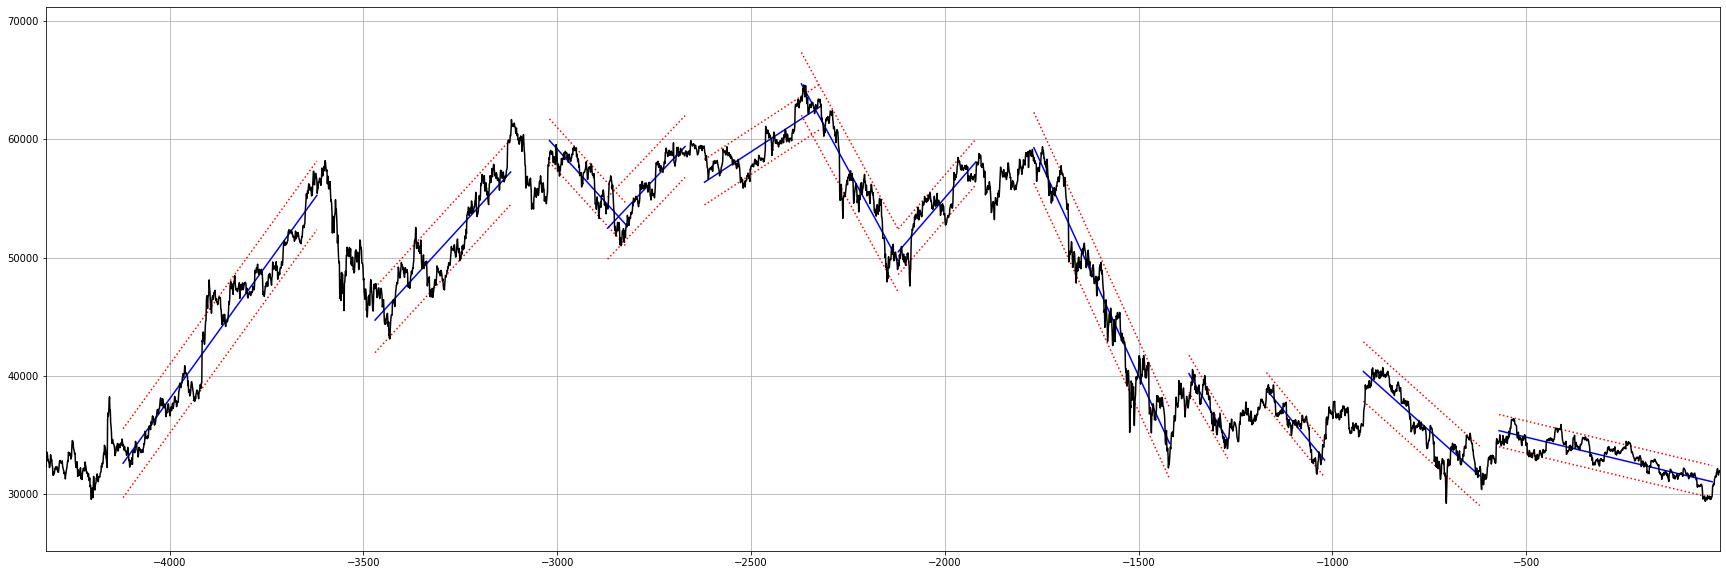

In [5]:
def regress(data, start, end):
    x = np.arange(start, end).reshape((-1, 1))
    y = data['Close'].iloc[start:end].values
    reg = LinearRegression().fit(x, y)

    return reg, reg.score(x, y), np.std(np.abs(y - reg.predict(x)))


n = 24 * 180
data = prepare_data(history)[-n:]

plt.figure(figsize = (30, 10))
ax = plt.gca()

step = 50
allowed_overlap = 1 * step
min_len, max_len = 100, 1000
indices = range(-n, 0, step)

trends = {}
for a, b in [(a, b) for a, b in product(indices, repeat=2) if min_len <= b - a <= max_len]:
    reg, score, std = regress(data, a, b)
    if score > .7 and std < 1000:
        trends[a, b] = reg, std

chosen = {}
for a, b in sorted(trends, reverse=True, key=lambda x: x[1] - x[0]): # sorted by trend length
    if all(bb <= a + allowed_overlap or b <= aa - allowed_overlap for aa, bb in chosen):
        chosen[a, b] = trends[a, b]

print(f'{len(trends)} trends found, from which {len(chosen)} do not overlap')

for (a, b), (reg, std) in chosen.items():
    x = np.array([a, b]).reshape((-1, 1))
    trend = reg.predict(x)
    lower = trend - 3*std
    upper = trend + 3*std

    plot_line(x, trend, ax, color='blue')
    plot_line(x, lower, ax, color='red', linestyle=':')
    plot_line(x, upper, ax, color='red', linestyle=':')

show_graph(data, ax)